In [1]:
import random
import numpy as np
import pandas as pd
import json
import cv2
import os
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import torchvision
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tqdm
import torch
random.seed(0)
np.random.seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

d:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
d:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
d:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
import torch
from pipeline.metrics import accuracy_b, log_loss_b
from pipeline.image_extracting import extract_faces, FastMTCNN

In [3]:
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter

In [4]:
fast_mtcnn = FastMTCNN(
    stride=4,
    resize=1,
    margin=14,
    factor=0.6,
    #min_face_size=20,
    #keep_all=True,
    select_largest=False,
    device=device
)
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
faces = extract_faces(r'D:\Machine Learning\deepfake-detection\data\train_sets\dfdc_train_part_0\olurfjfbcf.mp4',fast_mtcnn,None)

In [6]:
faces

[<PIL.Image.Image image mode=RGB size=1920x1080 at 0x24A73043B70>]

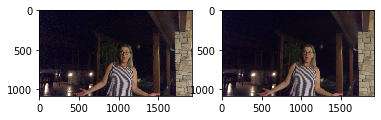

In [7]:
dst = cv2.fastNlMeansDenoisingColored(np.asarray(faces[0]),None,10,10,7,21)

plt.subplot(121),plt.imshow(np.asarray(faces[0]))
plt.subplot(122),plt.imshow(dst)
plt.show()

In [6]:
y0 = torch.tensor([0]*2000 + [1]*2000)
y = torch.FloatTensor([0.4215]*3686 + [0.5785]*314)
log_loss_b(y, y0), 0.6931

(tensor(0.6808), 0.6931)

In [8]:
2314 / 4000

0.5785

In [2]:
y_train = pd.read_csv('data\\frames\\metadata.csv')

In [3]:
y_train

,name,label
0,owxbbpjpch,1
1,vpmyeepbep,0
2,fzvpbrzssi,0
3,htorvhbcae,1
4,fckxaqjbxk,1
5,sphirandia,1
6,vsmadeuczx,1
7,ohaqlzfnuv,1
8,komngcqveq,1
9,iafvzgpbix,1


In [4]:
real = 0
fake = 0
for j in tqdm.tqdm_notebook(range(23, 24)):
    DATA_PATH = 'data\\frames\\dfdc_train_part_' + str(j) + '_img'
    files = os.listdir(DATA_PATH)
    for i in tqdm.tqdm_notebook(range(len(files))):
        if files[i] != 'metadata.json':
            y = y_train[y_train.name == files[i].split('.')[0]].label.values[0]
            if real < 2000 and y == 0:
                os.rename(DATA_PATH + '\\' + files[i], 'data\\validation_set\\real\\' + files[i])
                real += 1
            if fake < 2000 and y == 1:
                os.rename(DATA_PATH + '\\' + files[i], 'data\\validation_set\\fake\\' + files[i])
                fake += 1
            
            if fake == 2000 and real == 2000:
                print('STOP')

d:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


d:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


KeyboardInterrupt: 

In [33]:
y_train[y_train.name == 'aacehwwzol']

,name,label
100540,aacehwwzol,1


In [34]:
real = 0
fake = 0
DATA_PATH = 'data\\other\\frames\\faces_155'
files = os.listdir(DATA_PATH)
for i in tqdm.tqdm_notebook(range(len(files))):
    y = y_train[y_train.name == files[i].split('.')[0]].label.values[0]
    if real < 2000 and y == 0:
        os.rename(DATA_PATH + '\\' + files[i], 'data\\other\\validation_set\\real\\' + files[i])
        real += 1
    if fake < 2000 and y == 1:
        os.rename(DATA_PATH + '\\' + files[i], 'data\\other\\validation_set\\fake\\' + files[i])
        fake += 1

    if fake == 2000 and real == 2000:
        print('STOP')

d:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP
STOP


KeyboardInterrupt: 

In [22]:
y_train[y_train.name == 'owxbbpjpch'].label.values[0]

1

In [13]:
def extract_first_frame(video_path, frames_path, y_train):
    filename = video_path.split('\\')[-1].split('.')[0]
    y = y_train[y_train.name == filename].label.values[0]
    if y == 1:
        pth = frames_path + filename + '.jpg'
        vidcap = cv2.VideoCapture(video_path)
        success,image = vidcap.read()
        cv2.imwrite(pth, cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA) )  # save frame as JPEG file
    else:
        vidcap = cv2.VideoCapture(video_path)
        for i in range(5):
            pth = frames_path + filename + "." + str(i) + '.jpg'
            success,image = vidcap.read()
            cv2.imwrite(pth, cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA) )  # save frame as JPEG file

In [14]:
%%time
'''Extract first frame from each test video'''
DATA_PATH = 'data\\test_videos'
FRAMES_PATH = 'data\\test_videos_img\\img\\'
for file in os.listdir(DATA_PATH):
    if file != 'metadata.json':
        extract_first_frame(DATA_PATH + '\\' + file, FRAMES_PATH)

Wall time: 31.8 s


In [27]:
%%time
'''Extract first frame from each train video'''
for j in tqdm.tqdm_notebook(range(17, 18)):
    DATA_PATH = 'data\\train_sets\\dfdc_train_part_' + str(j)
    FRAMES_PATH = 'data\\frames\\dfdc_train_part_'+str(j)+'_img\\'
    files = os.listdir(DATA_PATH)
    for i in tqdm.tqdm_notebook(range(len(files))):
        if files[i] != 'metadata.json':
            extract_first_frame(DATA_PATH + '\\' + files[i], FRAMES_PATH, y_train)

d:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


d:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Wall time: 4min 27s


In [24]:
%%time
from PIL import ImageFilter, Image
''' Apply filters to images '''
filters = [
    ImageFilter.BLUR,
    ImageFilter.CONTOUR,
    ImageFilter.DETAIL,
    ImageFilter.EDGE_ENHANCE,
    ImageFilter.EDGE_ENHANCE_MORE,
    ImageFilter.EMBOSS,
    ImageFilter.FIND_EDGES,
    ImageFilter.SMOOTH,
    ImageFilter.SMOOTH_MORE,
    ImageFilter.SHARPEN
]
for j in tqdm.tqdm_notebook(range(0, 18)):
    FRAMES_PATH = 'data\\frames\\dfdc_train_part_'+str(j)+'_img\\'
    files = os.listdir(FRAMES_PATH)
    for i in tqdm.tqdm_notebook(range(len(files))):
        if files[i] != 'metadata.json':
            for fr in filters:
                im = Image.open(FRAMES_PATH + files[i])
                im = im.filter(fr)
                im.save(FRAMES_PATH + '.'.join(files[i].split('.')[:-1]) + '.' + str(fr).split("'")[1].split('.')[-1] +  '.jpg')

d:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Wall time: 15min 38s


In [26]:
%%time
''' Flip images '''
from PIL import Image
for j in tqdm.tqdm_notebook(range(11, 18)):
    FRAMES_PATH = 'data\\frames\\dfdc_train_part_'+str(j)+'_img\\'
    files = os.listdir(FRAMES_PATH)
    for i in tqdm.tqdm_notebook(range(len(files))):
        if files[i] != 'metadata.json':
            im = Image.open(FRAMES_PATH + files[i])
            im = im.transpose(Image.FLIP_LEFT_RIGHT)
            im.save(FRAMES_PATH + '.'.join(files[i].split('.')[:-1]) + '.flip.jpg')

d:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


d:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Wall time: 37min 2s


In [20]:
%%time

'''Gather metadata'''

FRAMES_PATH = 'data\\frames\\metadata.csv'
y_data = 'name,label'
for i in tqdm.tqdm_notebook(range(0, 18)):
    DATA_PATH = 'data\\train_sets\\dfdc_train_part_' + str(i)
    for file in os.listdir(DATA_PATH):
        if file == 'metadata.json':
            with open(DATA_PATH + '\\' + file) as r:
                parsed = json.loads(r.read())
                for name in parsed:
                    y_data += '\n' + name.split('.')[0] + ',' + str(int(parsed[name]['label'] == 'FAKE'))
with open(FRAMES_PATH, 'w') as w: 
    w.write(y_data)

Wall time: 966 ms
